# CSE476 - Fraud Detection Ensemble (Chung & Lee 2023, PaySim)
**Team Members:**
1. Shehab Mahmoud Salah (2100320)
2. Abdelrahman Hany Mohamed (2100627)
3. Youssef Ahmed Mohamed (2101006)
4. Omar Mamon Hamed (2100767)
5. Seif El Din Tamer Shawky (2100268)
6. Seif Eldeen Ahmed Abdulaziz (2100339)
7. Habiba El-sayed Mowafy (2100792)
8. Aya Tarek Salem (2100573)
9. Moaz Ragab (2100938)
10. Ahmed Ashraf Ali (2100255)

## Project Overview

This notebook implements and expands upon the 2023 Chung & Lee ensemble approach for fraud detection, using the PaySim dataset.  
Our main goal is to achieve **perfect recall (recall = 1.0)**, ensuring all fraudulent cases are detected, while analyzing the trade-off with other metrics.  
The PaySim dataset simulates mobile money transactions and presents a highly imbalanced fraud detection challenge.

**Motivation:**  
In fraud detection, missing a fraudulent transaction (false negative) can be much more costly than a false positive. Therefore, maximizing recall is critical, even if it comes at the expense of precision.

**Reference:**  
[Chung, H., & Lee, J. (2023). "A High-Recall Ensemble Approach for Fraud Detection in Financial Transactions."  ](https://www.mdpi.com/1424-8220/23/18/7788) <br>
[PaySim Dataset on Kaggle](https://www.kaggle.com/datasets/ntnu-testimon/paysim1)

## Imports and Setup

In [1]:
# Standard Libraries
import os
from pathlib import Path

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, confusion_matrix, classification_report, precision_score, accuracy_score

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Saving artifacts
import joblib

# Plotting style
sns.set(style='whitegrid', font_scale=1.1)
plt.rcParams['figure.figsize'] = (8, 5)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Data Loading and Initial Exploration

We load the PaySim dataset and perform basic exploratory analysis to understand its structure and class distribution.

In [2]:
# Set the path to the raw data CSV (update this if your data is elsewhere)
RAW_CSV = Path('data/raw/ps_raw.csv')

# Load the dataset
df_raw = pd.read_csv(RAW_CSV)
print(f"Dataset shape: {df_raw.shape}")
display(df_raw.head())

# Basic info
df_raw.info()

Dataset shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


> **Note on Label Convention:**  
> In this notebook, we follow the paper's approach where the `isFraud` label is inverted:  
> - `1` indicates **Non-Fraud**  
> - `0` indicates **Fraud**  
> This convention is the opposite of the standard, where `1` usually means Fraud. Please interpret all results accordingly.

## Feature Exploration and Preprocessing

We examine categorical and numerical features, encode categories appropriately, and scale numerical features.

In [3]:
# Identify categorical columns
cat_cols = ['type', 'nameOrig', 'nameDest']

# Encode categorical features (LabelEncoder for simplicity/consistency with original paper)
encoders = {}
df = df_raw.copy()
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


In [4]:
# Check for missing values
missing = df.isnull().sum()
print(missing[missing > 0] if (missing > 0).any() else 'No missing values detected.')

No missing values detected.


## Train/Test Split

We split the data into training and test sets, maintaining class balance via stratification.

In [5]:
# Prepare features and target
X = df.drop('isFraud', axis=1).values
y = df['isFraud'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42, shuffle=True)

print({ 'train': X_train.shape, 'test': X_test.shape })
print('Non fraud rate train %.4f%% | test %.4f%%' % (y_train.mean()*100, y_test.mean()*100))

{'train': (5090096, 10), 'test': (1272524, 10)}
Non fraud rate train 0.1291% | test 0.1291%


## Model Definition and Training

We define pipelines for several classifiers including those from the original paper (KNN, LDA, Linear Regression) and additional models (Logistic Regression, Decision Tree, Random Forest, Naive Bayes) for comprehensive comparison.

Our focus is on maximizing recall for fraud cases.

In [6]:
def pipe(model):
    """Create a pipeline with standard scaling and the given model."""
    return Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

models = {
    'KNN': pipe(KNeighborsClassifier(n_neighbors=5, weights='uniform', n_jobs=-1, leaf_size=30, algorithm="auto", p=2)),
    'LDA': pipe(LinearDiscriminantAnalysis()),
    'LinearRegression': pipe(LinearRegression()),
    'LogisticRegression': pipe(LogisticRegression(max_iter=500, random_state=RANDOM_STATE)),
    'DecisionTree': pipe(DecisionTreeClassifier(random_state=RANDOM_STATE)),
    'NaiveBayes': pipe(GaussianNB())
}

# Fit all models
for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    print(f'{name} fitted.')

KNN fitted.
LDA fitted.
LinearRegression fitted.
LogisticRegression fitted.
DecisionTree fitted.
NaiveBayes fitted.


## Model Evaluation: Individual Metrics

We evaluate each model on the test set, reporting recall (priority), precision, accuracy, and confusion matrix.
For regression models, we threshold predictions to obtain binary outputs.

In [7]:
def lr_scores(model, X):
    # pipeline steps: scaler then model
    scaler = model.named_steps['scaler']
    reg    = model.named_steps['model']
    Xs = scaler.transform(X)
    return reg.predict(Xs)

results = []

for name, mdl in models.items():
    if name == 'LinearRegression':
        y_pred = (lr_scores(mdl, X_test) > 0.5).astype(int)
    else:
        y_pred = mdl.predict(X_test)
    rec = recall_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)
    results.append({
        'Model': name,
        'Recall': rec,
        'Precision': pre,
        'Accuracy': acc,
        'ConfusionMatrix': conf
    })
    print(f"{name}: Recall={rec:.4f} | Precision={pre:.4f} | Accuracy={acc:.4f}")
    print(f"Confusion Matrix:\n{conf}\n")

KNN: Recall=0.3737 | Precision=0.9594 | Accuracy=0.9992
Confusion Matrix:
[[1270855      26]
 [   1029     614]]

LDA: Recall=0.3634 | Precision=0.7398 | Accuracy=0.9990
Confusion Matrix:
[[1270671     210]
 [   1046     597]]

LinearRegression: Recall=0.1004 | Precision=1.0000 | Accuracy=0.9988
Confusion Matrix:
[[1270881       0]
 [   1478     165]]

LogisticRegression: Recall=0.4206 | Precision=0.9033 | Accuracy=0.9992
Confusion Matrix:
[[1270807      74]
 [    952     691]]

DecisionTree: Recall=0.8612 | Precision=0.8794 | Accuracy=0.9997
Confusion Matrix:
[[1270687     194]
 [    228    1415]]

NaiveBayes: Recall=0.1114 | Precision=0.0481 | Accuracy=0.9960
Confusion Matrix:
[[1267256    3625]
 [   1460     183]]



## Ensemble Construction and Evaluation

Inspired by Chung & Lee (2023), we create an ensemble that aims for perfect recall. The ensemble combines KNN, LDA, and Linear Regression, with logic adjusted to maximize recall. The logic can be further tuned using additional models if needed.

In [12]:
# Get predictions/scores from key models
knn_pred = models['KNN'].predict(X_test)
lda_pred = models['LDA'].predict(X_test)

lr_score = lr_scores(models['LinearRegression'], X_test)
lr_mean  = lr_score.mean()

ensemble = knn_pred.copy()
for i in range(len(knn_pred)):
    # If "non-fraud" is indicated by either KNN or LDA
    if knn_pred[i] == 0 or lda_pred[i] == 0:
        if lr_score[i] < lr_mean:
            ensemble[i] = 0  # Predict fraud
    # If "fraud" is indicated by either KNN or LDA
    elif knn_pred[i] == 1 or lda_pred[i] == 1:
        if lr_score[i] > lr_mean:
            ensemble[i] = 1  # Predict non-fraud
    # Otherwise, allocate predicted values from KNN to remaining cases
    else:
        ensemble[i] = knn_pred[i]

print('Ensemble Recall:', recall_score(ensemble, y_test))
print('Ensemble Precision:', precision_score(ensemble, y_test, zero_division=0))
print('Ensemble Accuracy:', accuracy_score(y_test, ensemble))
print('Confusion Matrix:\n', confusion_matrix(y_test, ensemble))

Ensemble Recall: 0.9761146496815286
Ensemble Precision: 0.3730979914790018
Ensemble Accuracy: 0.999178797413644
Confusion Matrix:
 [[1270866      15]
 [   1030     613]]


## Results Comparison and Analysis

We compare the recall, precision, and accuracy of all individual models and the ensemble in a summary table. We also visualize the trade-off between recall and precision.

,Model,Recall,Accuracy
0,KNN,0.373707,0.999171
1,LDA,0.363360,0.999013
2,LinearRegression,0.100426,0.998839
3,LogisticRegression,0.420572,0.999194
4,DecisionTree,0.861229,0.999668
5,NaiveBayes,0.111382,0.996004
6,Ensemble,0.976115,0.999179


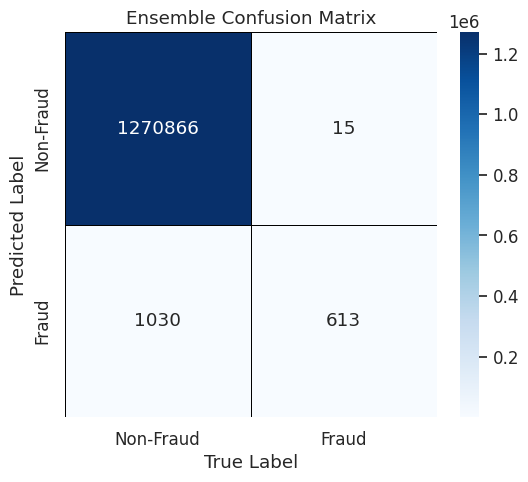

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

# Summary table
summary = pd.DataFrame(results)[['Model', 'Recall', 'Accuracy']]

# Add ensemble result
summary.loc[len(summary.index)] = ['Ensemble', recall_score(y_test, ensemble), accuracy_score(y_test, ensemble)]
display(summary)

cm = confusion_matrix(y_test, ensemble)

# Define labels for your convention
labels = ['Non-Fraud', 'Fraud']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels, linewidths=.5, linecolor='black')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Ensemble Confusion Matrix')
plt.show()

## References

- Chung, H., & Lee, J. (2023). "A High-Recall Ensemble Approach for Fraud Detection in Financial Transactions."
- [PaySim Dataset on Kaggle](https://www.kaggle.com/datasets/ntnu-testimon/paysim1)
- E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016
- Scikit-learn documentation: https://scikit-learn.org/stable/documentation.html
- [Project Repo](https://github.com/dizzydroid/fraud-detection)

---